# Configuration initiale

In [1]:
# Souhaite-t-on générer des commentaires différents selon le type de vin ?
with_type = True

In [2]:
# Imports utiles :
!pip install transformers
from transformers import GPT2Tokenizer, TFGPT2LMHeadModel
import tensorflow as tf
import numpy as np
import pandas as pd
import re

     |████████████████████████████████| 2.0MB 8.8MB/s 
     |████████████████████████████████| 890kB 54.2MB/s 
     |████████████████████████████████| 3.2MB 51.4MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp37-none-any.whl size=893262 sha256=5a8bfe0e432fde7e85e3fe92fb1920371f5ed34cda1a65110b4dbd225daef1f8
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [3]:
# Spécifique à l'exécution sur Google Colab : pour accéder à l'ensemble des fichiers et répertoires utiles
from google.colab import drive
drive.mount('/drive')
%cd /drive/MyDrive/data/pipotron/
%pwd
%ls -al

Mounted at /drive
/drive/MyDrive/data/pipotron
total 116
drwx------ 2 root root  4096 Mar 16 10:48 donnees/
drwx------ 2 root root  4096 Mar 16 10:40 .git/
-rw------- 1 root root  1819 Mar 16 11:10 .gitignore
drwx------ 2 root root  4096 Mar 16 10:46 models/
drwx------ 2 root root  4096 Mar 19 09:32 output/
-rw------- 1 root root 99839 Mar 26 09:09 pipotron_entrainement.ipynb
-rw------- 1 root root    79 Mar 16 10:40 README.md


In [4]:
# Configuration du tokenizer :

# On va s'appuyer sur un modèle de générateur GPT-2 (merci OpenAI) pré-entraîné sur la langue française (merci Antoine Louis),
# et on utilise la bibliothèque transformers (merci à HuggingFace):
model_name = "antoiloui/belgpt2"
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
nb_added_tokens = 0

# On ajoute au tokenizer des tokens de "déclenchement" (en début de séquence, pour indiquer que ce qui suit est un commentaire de vin) et de padding

# Tokens de déclenchement
L_first_tokens = ["<|review|>"]
if with_type:
  L_first_tokens += ["<|blanc|>", "<|rouge|>"]  
print(L_first_tokens)

nb_added_tokens += tokenizer.add_special_tokens({'pad_token': "<|pad|>", 'eos_token':"<|end|>"})
if len(L_first_tokens)>0:
    nb_added_tokens += tokenizer.add_special_tokens({'additional_special_tokens': L_first_tokens})
print(nb_added_tokens, "token(s) ajoutés")

# On vérifie la bonne définition des tokens de padding et de fin de séquence :
print(tokenizer.pad_token, ":", tokenizer.pad_token_id)
assert tokenizer.pad_token_id!=None
print(tokenizer.eos_token, ":", tokenizer.eos_token_id)
assert tokenizer.eos_token_id!=None


['<|review|>', '<|blanc|>', '<|rouge|>']
5 token(s) ajoutés
<|pad|> : 50257
<|end|> : 50258


# Entraînement du modèle

In [5]:
# Chargement des données disponibles :

from_full_table = False  # Je ne mets pas les données complètes (non publiques) sur le GitHub, seulement l'extraction utile ici
reviews_filename = "donnees/reviews.csv"

if from_full_table:
  # Chargement du fichier complet, issu du scraping du site larvf.com (données accessibles par abonnement, non publiques):
  DF_rvf = pd.read_csv("/drive/MyDrive/donnees/larvf_2020-11-24.csv")
  print("Nombre de revues textuelles disponibles :", len(DF_rvf)-DF_rvf['review_text'].isna().sum())
  #display(DF_rvf.info())
  #display(DF_rvf['vintage_twitterimg'].value_counts())
  #display(DF_rvf['wine_types'].value_counts())

  # On sélectionne les colonnes qui nous intéressent en retirant les valeurs manquantes, et on fait un mélange aléatoire: 
  DF_reviews = DF_rvf[~DF_rvf['review_text'].isna()][['wine_types', 'vintage_twitterimg', 'review_text']]
  DF_reviews = DF_reviews.sample(frac=1, random_state=57840).drop_duplicates().reset_index(drop=True)
  print("Nombre de revues textuelles après suppression des doublons :", len(DF_reviews))
  
  # On enregistre ces données pour ce cas d'usage:
  DF_reviews.to_csv(reviews_filename, header=True, index=False)

else:
  DF_reviews = pd.read_csv(reviews_filename)
  print("Nombre de revues :", len(DF_reviews))

display(DF_reviews.head(5))


Nombre de revues : 30310


,wine_types,vintage_twitterimg,review_text
0,"Effervescent, Extra-brut, Dosage : 2 g/l extra...",bouteille-vin-champagne-rose.jpg,"Salivant, énergique et élancé sur des langoust..."
1,"Tranquille, Sec, Tranquille, Sec, Tranquille, Sec",bouteille-vin-corse-rouge.jpg,"Plus en finesse, 1769 Sciaccarellu offre plus ..."
2,NaN,bouteille-vin-bourgogne-rouge.jpg,"Vin puissant, viril, marqué par le caractère v..."
3,"Tranquille, Sec",bouteille-vin-languedoc-rouge.jpg,"jus équilibré et vif, bien en place."
4,"Tranquille, Sec, Tranquille, Sec, Tranquille, ...",bouteille-vin-bordeaux-rouge.jpg,"Un vin campé sur son élevage, avec un fruit fi..."


In [9]:
# Préparation des données:
import re

# On ajoute un nouveau mot (token) qui a vocation à servir de déclencheur pour générer un nouveau commentaire de dégustation.
# On supprime également les informations de date du commentaire, parfois présentes.
# Enfin on ajoute un token de fin de séquence pour inciter le modèle à produire des commentaires de taille raisonnable.
def prepare_review(S_line):
  review = S_line['review_text']
  review = re.sub(r"\([^\(\)]*\.[0-9][0-9][0-9][0-9]\)", "", review.strip())
  review = re.sub(r"[0-9]*\s?\%", "", review)  # On supprime les pourcentages car notre générateur n'est pas bon en calcul...
  review = re.sub("\(\)", "", review)  # Suppression des parenthèses inutiles
  review = re.sub(r"\s+", " ", review.strip()) + " <|end|>"  # Suppression des espaces inutiles et ajout du token de fin
  if with_type:
    wine_type = ""
    # if isinstance(S_line['wine_types'], str) and ("Effervescent" in S_line['wine_types']):
    #   wine_type = "efferv"
    # elif isinstance(S_line['wine_types'], str) and ("Moelleux" in S_line['wine_types']):
    #   wine_type = "moelleux"
    if isinstance(S_line['vintage_twitterimg'], str) and ("blanc" in S_line['vintage_twitterimg']):
      wine_type = "blanc"
    elif isinstance(S_line['vintage_twitterimg'], str) and ("rouge" in S_line['vintage_twitterimg']):
      wine_type = "rouge"
    if wine_type!="":
      return L_first_tokens[0] + f" <|{wine_type}|> {review}"
    else:
      return None
  else:
    return L_first_tokens[0] + " " + review

L_reviews = list(DF_reviews.apply(prepare_review, axis=1).dropna())
print("Nombre de revues conservées :", len(L_reviews))
if with_type:
  display(pd.Series(L_reviews).apply(lambda s: s.split(" ")[1]).value_counts())

# Affichons le résultat de cette préparation sur quelques lignes:
for i in range(0,10):
  print(L_reviews[np.random.randint(0, len(L_reviews))])

Nombre de revues conservées : 28905


<|rouge|>    15008
<|blanc|>    13897
dtype: int64

<|review|> <|blanc|> Compact, gras, dense, peu disert de prime abord mais de haute tenue, il dévoile sa formidable constitution en bouche, incarnant le lien rêvé entre le raisin et le caillou. Il semble indestructible et en même temps très sensuel. Un seigneur pour la table, à boire sans urgence, sur au moins dix ans. <|end|>
<|review|> <|blanc|> Boisé très marqué, notes de grillé et toasté, dommage car la matière est là. <|end|>
<|review|> <|blanc|> Très beau blanc de blancs taillé pour la garde, équilibrée entre puissance et suavité. <|end|>
<|review|> <|rouge|> Vif et croquant, ce simple rouge possède des tanins un peu rustiques mais qui pourront se fondre. La rusticité ne disparaîtra pas, mais contribuera au caractère du vin. <|end|>
<|review|> <|rouge|> Par son équilibre et sa profondeur, ce 2014 ravira aussi bien dès la fin de l’année que dans dix ans. <|end|>
<|review|> <|blanc|> Comment ne pas être transporté par le crémeux de ce Grand Cru, à la bouche pleine, moelleuse, intens

In [10]:
# On charge le modèle de "transfer learning" et on le prépare à recevoir nos nouveaux tokens:
model = TFGPT2LMHeadModel.from_pretrained(model_name)
_ = model.resize_token_embeddings(tokenizer.vocab_size + nb_added_tokens)

All model checkpoint layers were used when initializing TFGPT2LMHeadModel.

All the layers of TFGPT2LMHeadModel were initialized from the model checkpoint at antoiloui/belgpt2.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2LMHeadModel for predictions without further training.


In [11]:
# On vérifie qu'un commentaire de vin est inchangé après tokenisation puis détokenisation:
i = np.random.randint(0, len(L_reviews))
print(L_reviews[i])
print(tokenizer.decode(tokenizer.encode(L_reviews[i])))
assert L_reviews[i] == tokenizer.decode(tokenizer.encode(L_reviews[i]))

<|review|> <|blanc|> Un melon poussé en surmaturité pour offrir un blanc suave, à la sucrosité légère. Un bon rafraîchissement à l'apéritif. <|end|>
<|review|> <|blanc|> Un melon poussé en surmaturité pour offrir un blanc suave, à la sucrosité légère. Un bon rafraîchissement à l'apéritif. <|end|>


Nombre maximal de tokens retenu (seuil) : 64.0
Nombre de revues conservées : 26130


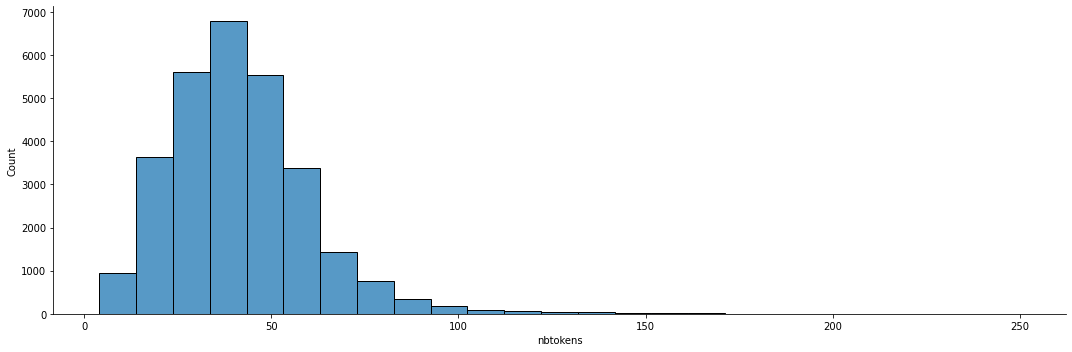

In [12]:
# Pour limiter les calculs inutiles et le besoin de padding, on ne va garder que 90% des revues, celles ayant le plus faible nombre de tokens.
# (Pareto est notre ami :-))

import seaborn as sns
unpadded = tokenizer(L_reviews, padding=False)
L_nbtokens = [len(t) for t in unpadded.input_ids]
DF_nbtokens = pd.DataFrame(pd.Series(L_nbtokens, name='nbtokens'))
sns.displot(kind='hist', data=DF_nbtokens, x='nbtokens', bins=25, aspect=3)
threshold = DF_nbtokens.nbtokens.quantile(0.9)
print("Nombre maximal de tokens retenu (seuil) :", threshold)

L_short_reviews = [L_reviews[i] for i in range(0, len(L_reviews)) if L_nbtokens[i]<=threshold]
print("Nombre de revues conservées :", len(L_short_reviews))

In [13]:
# On prépare les données d'entraînement du générateur:
# Le générateur prédit le mot suivant pour chaque mot (ou plutôt token, en l'occurrence wordpiece) du texte fourni en entrée.
# Donc l'ensemble d'apprentissage est constitué de tuples (x=entrée, y=sortie) où y est un décalage de x d'un token vers la droite.
# On prévoit aussi un ensemble de test afin de pouvoir évaluer le surapprentissage.

batch_size = 16
train_size = int(0.80*len(L_short_reviews)/batch_size)*batch_size
print("Taille des batches :", batch_size)
print("Nombre de lignes dans la base d'apprentissage :", train_size)

encodings = tokenizer(L_short_reviews, padding=True, return_tensors='tf')
input_ids = encodings.input_ids
attention_mask = encodings.attention_mask
x = {'input_ids': input_ids[:, :-1], 'attention_mask': attention_mask[:, :-1]}
y = input_ids[:, 1:]
assert x['input_ids'].shape == y.shape
assert x['attention_mask'].shape == y.shape
full_dataset = tf.data.Dataset.from_tensor_slices((x, y))
train_dataset = full_dataset.take(train_size).batch(batch_size).repeat()
test_dataset = full_dataset.skip(train_size).batch(batch_size)

Taille des batches : 16
Nombre de lignes dans la base d'apprentissage : 20896


In [14]:
# On "encapsule" le modèle initial dans un modèle qui ne renvoie que les "logit" des probabilités des mots,
# ce à quoi on peut appliquer la fonction de coût classique (entropie croisée)

class Pipotron(tf.keras.Model):
  def __init__(self, model):
    super().__init__(name="Pipotron")
    self.gpt2 = model
  def __call__(self, input, training=False):    
    y = self.gpt2(input, training=training)
    return y.logits

pipotron = Pipotron(model)

In [15]:
# On contrôle les formats d'entrée et de sortie du modèle (à ce stade il est déboussolé par notre token de déclenchement):
for features, labels in train_dataset.take(1):
  i=4
  for k in features.keys():
    print(k, ":", features[k].shape)
  print(tokenizer.decode(features['input_ids'][i], skip_special_tokens=False))
  print("labels :", labels.shape)
  print(tokenizer.decode(labels[i], skip_special_tokens=False))
  z = pipotron(features)
  print("output :", z.shape)


input_ids : (16, 63)
attention_mask : (16, 63)
<|review|> <|blanc|> Toujours de la justesse dans les profils aromatiques, très bien gérée. La bouche déroule un jus sec et soyeux, sans lourdeur, l'élevage est à sa place, équilibré, toute la pureté et l'énergie dans ce chardonnay très bien façonné. <|end|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|>
labels : (16, 63)
<|blanc|> Toujours de la justesse dans les profils aromatiques, très bien gérée. La bouche déroule un jus sec et soyeux, sans lourdeur, l'élevage est à sa place, équilibré, toute la pureté et l'énergie dans ce chardonnay très bien façonné. <|end|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|>
output : (16, 63, 50262)


In [16]:
# Paramétrage de l'entraînement :

# TO DO : idéalement, appliquer un learning_rate dégressif (scheduler)

optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
pipotron.compile(optimizer=optimizer, loss=loss)

In [17]:
# ENTRAINEMENT (fine tuning) DU MODELE :

# Pour bien voir la progression, on affiche le score à chaque 'round' (pseudo-epoch, qui est en fait une subdivision de la 'vraie'
# epoch qui consisterait à passer toute la base d'entraînement une seule fois):
nb_epochs = 5
nb_steps_per_round = 400
nb_rounds = (nb_epochs*len(L_short_reviews))//(batch_size*nb_steps_per_round)
print("Nombre d'étapes (rounds) d'entraînement prévues :", nb_rounds)
H_history = pipotron.fit(train_dataset, validation_data=test_dataset, epochs=nb_rounds, steps_per_epoch=nb_steps_per_round)

Nombre d'étapes (rounds) d'entraînement prévues : 20
Epoch 1/20
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else statement not yet supported
To silen

In [18]:
# Sauvegarde du modèle:
import time

fullpath = "models/pipotron_" + str(int(time.time()/60))
model.save_pretrained(fullpath)
print("MODEL SAVED AT :", fullpath)

MODEL SAVED AT : models/pipotron_26945889


# Chargement du modèle (pipotron) déjà entraîné

In [ ]:
# Rechargement du modèle, si besoin :

fullpath = "models/pipotron_26945889"
model = TFGPT2LMHeadModel.from_pretrained(fullpath)

All model checkpoint layers were used when initializing TFGPT2LMHeadModel.

All the layers of TFGPT2LMHeadModel were initialized from the model checkpoint at models/pipotron_26934435.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2LMHeadModel for predictions without further training.


# Utilisation et test du pipotron

In [20]:
# On affiche des commentaires générés par le modèle entraîné et on choisit une combinaison de top_k, top_p :

def pipote(top_k=30, top_p=0.85, repetition_penalty=1.3, max_length=200, skip_special_tokens=True, wine_type="", return_first_tokens=True):
  first_tokens = L_first_tokens[0]
  if with_type:
    type_token = f"<|{wine_type}|>"
    if type_token not in L_first_tokens:
      type_token = L_first_tokens[1:][np.random.randint(len(L_first_tokens)-1)]
    first_tokens += " " + type_token  
  input = tokenizer.encode(first_tokens, return_tensors='tf')

  output = model.generate(
      input_ids=input,
      max_length=max_length,
      do_sample=True,
      pad_token_id=tokenizer.pad_token_id,
      eos_token_id=tokenizer.eos_token_id,
      top_k=top_k,
      top_p=top_p,  # 1 = pas de sélection liée au total des probabilités estimées
      repetition_penalty=repetition_penalty
  )

  review = tokenizer.decode(output[0], skip_special_tokens=skip_special_tokens)
  review = re.sub(r"\s+", " ", review)
  review = re.sub(r"\.+", ".", review)
  review = re.sub(r"\"", "", review)

  if return_first_tokens:
    return first_tokens, review
  else:
    return review


nb_comments = 20
grid_search = True

if grid_search==True:
  L_top_k = [25, 30, 40]
  L_top_p = [0.75, 0.85, 0.95]
else:
  L_top_k = [30]
  L_top_p = [0.85]

for top_k in L_top_k:
  for top_p in L_top_p:
    print()
    print("###### TOP_K =", top_k, "; TOP_P =", top_p)    
    for i in range(0, nb_comments):
      first_tokens, review = pipote(top_k, top_p)
      print("  ", first_tokens, "/", review)



###### TOP_K = 25 ; TOP_P = 0.75
   <|review|> <|blanc|> / Le nez est complexe et offre des notes de fruits secs, de noisette. Bouche ample mais avec une belle fraîcheur, finale minérale, un peu sèche en fin de bouche.
   <|review|> <|blanc|> / Un vin demi-sec, à la bouche assez fine et équilibrée.
   <|review|> <|rouge|> / Nez intense de fruits rouges, avec des notes d’épices et une touche poivrée. Bouche charnue, aux tanins soyeux et mûrs, à la finale marquée par le boisé. Un vin complet au caractère affirmé.
   <|review|> <|rouge|> / Un nez qui évoque la truffe et une bouche tout en volume avec un fruit net. Un vin gourmand et bien construit, au grain fin mais très précis dans sa texture.
   <|review|> <|blanc|> / Encore fermé, le nez dévoile des notes de fruits mûrs. La bouche est élégante avec une jolie finale sur la fleur blanche et les agrumes. Un vin qui garde un bel équilibre grâce à sa fraîcheur.
   <|review|> <|rouge|> / Ce 2015 est un peu marqué par son élevage. Il faudra 

In [25]:
# Quelques vérifications que le modèle ne reproduit pas trop à l'identique les commentaires de la base d'apprentissage :

def cherche(s):
  L_found = [r for r in L_short_reviews if s in r]
  print()
  print(f"Nombre d'occurrences de \"{s}\" :", len(L_found))
  for found in L_found:
    print(found)

cherche("finale marquée par le boisé")
cherche("belle tension aromatique")
cherche("fruit charnu et généreux")
cherche("boisé qui lui va bien")
cherche("évoquent la coriandre fraîche")
cherche("joli fruit juteux")
cherche("charnu, soyeux en finale")



Nombre d'occurrences de "finale marquée par le boisé" : 0

Nombre d'occurrences de "belle tension aromatique" : 0

Nombre d'occurrences de "fruit charnu et généreux" : 0

Nombre d'occurrences de "boisé qui lui va bien" : 2
<|review|> <|blanc|> Beau style frais, avec un boisé qui lui va bien. C'est un 2015 qui a une bonne tenue, svelte, tendu, gérant la richesse de son millésime. Un chardonnay qui a encore tout son temps devant lui ! <|end|>
<|review|> <|rouge|> Un jus déjà plus élaboré, un pinot noir concentré, juteux, précis, avec une forme d'équilibre, un boisé qui lui va bien. Le meilleur vin de cette gamme d'Antonin Rodet. <|end|>

Nombre d'occurrences de "évoquent la coriandre fraîche" : 0

Nombre d'occurrences de "joli fruit juteux" : 3
<|review|> <|rouge|> Un très joli fruit juteux dans une texture souple. Un vin confortable, au cœur de bouche plein, soyeux, gourmand. <|end|>
<|review|> <|rouge|> Très bien constitué, avec une trame minérale intense et un joli fruit juteux. Une 

In [ ]:
# On produit ici un fichier de commentaires générés par le modèle :

%pwd
%ls -al

if with_type:
  output_filename = "output/generated_with_type.csv"
else:
  output_filename = "output/generated.txt"

nb_comments = 600

print("En cours...")
with open(output_filename, 'a') as file:
  for i in range(0, nb_comments):
    first_token, review = pipote()
    line = f"\"{first_token}\",\"{review}\"\n"
    file.write(line)
    if i%10==9:
      print("#####", i+1, "commentaires générés et enregistrés.")
      print(first_token, "///", review, sep='')


total 148
drwx------ 2 root root   4096 Mar 16 10:48 donnees/
drwx------ 2 root root   4096 Mar 16 10:40 .git/
-rw------- 1 root root   1819 Mar 16 11:10 .gitignore
drwx------ 3 root root   4096 Mar 26 10:09 models/
drwx------ 2 root root   4096 Mar 19 09:32 output/
-rw------- 1 root root 132519 Mar 26 10:38 pipotron_entrainement.ipynb
-rw------- 1 root root     79 Mar 16 10:40 README.md
En cours...
##### 10 commentaires générés et enregistrés.
<|review|> <|rouge|>///La matière est bien présente dans ce vin encore en élevage, avec des tanins un peu rugueux.
##### 20 commentaires générés et enregistrés.
<|review|> <|blanc|>///Un sauvignon croquant, bien mûr et frais. On se régalera de son fruit pur, sans concession dans ce millésime solaire.
##### 30 commentaires générés et enregistrés.
<|review|> <|rouge|>///Délicieux cabernet franc sanguin, élevé sous bois et en demi-muids. Un beau classique à boire sur le croquant de son fruit.
##### 40 commentaires générés et enregistrés.
<|review|>

SyntaxError: ignored